# PCA components filters (weights) and patterns (scores) visualization

### Imports

In [1]:
import os
import re
import glob
import os
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
from time import time
import pywt
import mne
import scipy
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import cesium.featurize
from plotly.subplots import make_subplots
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, BaseEstimator

import sys

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
import mne

import matplotlib.pyplot as plt
import seaborn as sns

from rumination_experiment_transformers_averaged_CDS import *

import warnings

warnings.filterwarnings("ignore")


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load pickled ERN and Pe results

In [3]:
results_ern = pd.read_pickle("../public_data/results/models_pickles/ern_results_with_external-p.pkl")
results_pe = pd.read_pickle("../public_data/results/models_pickles/pe_results_with_external-p.pkl")

## Extract PCA-pipeline for both ERN ROIs

In [4]:
# ROI 1
roi_1_pipeline = results_ern.pre_processed_pipeline.iloc[9]
roi_1 = roi_1_pipeline['channels_extraction'].channels_list

print(roi_1_pipeline)
print(roi_1)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'Fz', 'FCz', 'Cz',
                                             'CPz', 'P1', 'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'Fz', 'FCz', 'Cz', 'CPz', 'P1', 'Pz', 'P2']


In [5]:
# ROI 2
roi_2_pipeline = results_ern.pre_processed_pipeline.iloc[15]
roi_2 = roi_2_pipeline['channels_extraction'].channels_list

print(roi_2_pipeline)
print(roi_2)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2',
                                             'FCz', 'C1', 'Cz', 'C2', 'CPz',
                                             'P1', 'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FCz', 'C1', 'Cz', 'C2', 'CPz', 'P1', 'Pz', 'P2']


## Extract PCA-pipeline for both Pe ROIs

In [7]:
# ROI 3
roi_3_pipeline = results_pe.pre_processed_pipeline.iloc[13]
roi_3 = roi_3_pipeline['channels_extraction'].channels_list

print(roi_3_pipeline)
print(roi_3)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'Fz', 'FCz', 'C1',
                                             'Cz', 'C2', 'CPz', 'P1', 'Pz',
                                             'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()), ('baseline', ErnBaselined()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'Fz', 'FCz', 'C1', 'Cz', 'C2', 'CPz', 'P1', 'Pz', 'P2']


In [8]:
# ROI 4
roi_4_pipeline = results_pe.pre_processed_pipeline.iloc[1]
roi_4 = roi_4_pipeline['channels_extraction'].channels_list

print(roi_4_pipeline)
print(roi_4)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2',
                                             'FC1', 'FCz', 'FC2', 'C1', 'Cz',
                                             'C2', 'CP1', 'CPz', 'CP2', 'P1',
                                             'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()), ('baseline', ErnBaselined()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2', 'C1', 'Cz', 'C2', 'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2']


---

## Load data

In [11]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [12]:
X_train_df = epochs_df

---

## Visualize channels in ROIs

In [18]:
def plot_roi(channels_list, roi_name, save=False):
    cm = 1/2.54
    dpi = 200

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 1
    plt.rc('font', size=7)

    sns.set_palette('deep')
    palette = sns.color_palette("tab10")
    red = palette[3]


    X_df = X_train_df
    X_df_copy = pd.DataFrame(copy.deepcopy(X_df.to_dict()))

    epochs_full = mne.concatenate_epochs([epoch['error_response'] for epoch in epochs_df.epoch.to_list()])

    channels = epochs_full[0].info['ch_names']
    mask = np.isin(channels, channels_list)
    mask = mask.reshape(mask.shape[0], -1) 
    mask = np.repeat(mask, 181, axis=1)


    evoked_array = mne.EvokedArray(np.zeros((64,181)), epochs_full.info)

    mask_params = dict(
        marker='o', 
        markerfacecolor=red, 
        markeredgecolor=red,
        linewidth=0, 
        markersize=12
    )

    fig = evoked_array.plot_topomap(
        times=0, 
        mask=mask,
        # show_names=True,
        cmap='binary',
        show=False,
        colorbar=False, 
        mask_params=mask_params,
        outlines='head',
        sphere='auto'
    )
    axis = fig.axes[0]
    axis.set_title('')

    fig.set_size_inches(5*cm, 5*cm) 

    plt.show()

    if save:
        fig.savefig(f'roi_{roi_name}_dpi_{dpi}_color', bbox_inches='tight')
    

Not setting metadata
1635 matching events found
No baseline correction applied


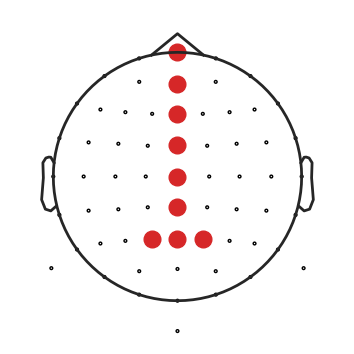

In [19]:
# ROI 1
plot_roi(roi_1, "1", save=False)

Not setting metadata
1635 matching events found
No baseline correction applied


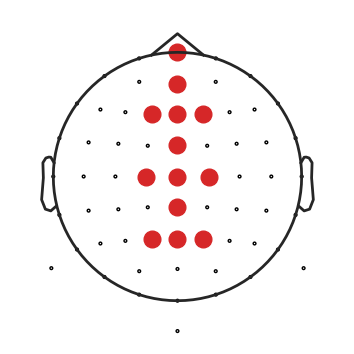

In [20]:
# ROI 2
plot_roi(roi_2, "2", save=False)

Not setting metadata
1635 matching events found
No baseline correction applied


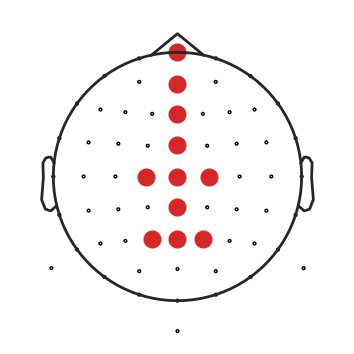

In [21]:
# ROI 3
plot_roi(roi_3, "3", save=False)

Not setting metadata
1635 matching events found
No baseline correction applied


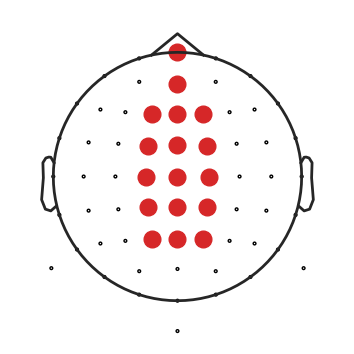

In [22]:
# ROI 4
plot_roi(roi_4, "4", save=False)

---

## Visualize components' patterns and filters

In [13]:
def setup_patterns_and_filters_for_plotting(X_patterns, X_filters, epochs):
    
    patterns_evokes = np.array([mne.EvokedArray(pattern, epochs.info, tmin=epochs.tmin) for pattern in X_patterns])
    patterns_grand_averages = np.array([np.mean(pattern.get_data(), axis=0) for pattern in patterns_evokes])
    
    filters_evokes = np.array([mne.EvokedArray(filter_, epochs.info) for filter_ in X_filters])
    filters_ = np.array([filter_.get_data().reshape(-1) for filter_ in filters_evokes])
    
    ########################################################################################
    patterns_df = pd.DataFrame()

    for index, pattern in enumerate(patterns_grand_averages):
        this_pattern = pd.DataFrame()
        this_pattern['Time'] = np.linspace(-0.1,0.6,181)
        this_pattern['Voltage'] = pattern *1000000 # resale to uV
        this_pattern['PCA'] = len(pattern)*np.array(0) + index + 1
        
        patterns_df = pd.concat([patterns_df, this_pattern])
        
    
    return patterns_df, patterns_evokes, filters_, filters_evokes

In [14]:
def extract_filters_patterns(roi_pipeline, roi, X):
    X_df_copy = pd.DataFrame(copy.deepcopy(X.to_dict()))

    # extract PCA components (eigenvectors)
    components = roi_pipeline['spatial_filter'].components_

    # create MNE object with sensors within ROI
    epochs_full = mne.concatenate_epochs([epoch['error_response'] for epoch in X.epoch.to_list()])
    epochs_full = epochs_full.pick_channels(roi, ordered=True)

    # compute grand average of EEG signal within ROI
    evokeds = np.array([epoch['error_response'].average() for epoch in X.epoch.to_list()])
    X_channels_mean = np.mean(np.array([evoked.get_data(picks=roi) for evoked in evokeds]), axis=0)


    # center data
    X_channels_mean_t = X_channels_mean.T
    m = np.mean(X_channels_mean_t, axis=0)
    X_channels_mean_t -= m   

    # create components scores (patterns)
    X_patterns = np.array([(X_channels_mean_t * component).T for component in components])
    
    # create filters (simply weights)
    X_filters = np.array([component.reshape(X_channels_mean.shape[0],-1) for component in components])
    
    patterns_df, patterns_evokes, filters_, filters_evokes = setup_patterns_and_filters_for_plotting(X_patterns, X_filters, epochs_full)
    
    return patterns_df, patterns_evokes, filters_, filters_evokes  

In [23]:
def plot_ern_patterns_filters(patterns_df, patterns_evokes, filters_, filters_evoked, roi_name, save=False):
    cm = 1/2.54
    dpi = 200

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5

    sns.set_palette('deep')

    g = sns.FacetGrid(
        data=patterns_df, 
        col='PCA', 
        sharey=False, 
        despine=False,
        gridspec_kws={"wspace":0.25}
    )


    g.map(sns.lineplot, 'Time', 'Voltage')

    g.set(xlim=(-0.106, 0.405))
    g.set(xticks=np.arange(-0.1,0.5,0.1))

    # set y axes limits
    axes = g.axes.flatten()

    # ERN ROI smaller
    axes[0].set_ylim([-3.3, 4.3])
    axes[1].set_ylim([-1.2, 1.5])
    axes[2].set_ylim([-0.6, 0.6])
    axes[3].set_ylim([-0.11, 0.11])


    fig = g.fig
    ################################################################
    ############## ADD FILTERS #####################################

    # first filter
    filter_0_axis = fig.add_axes([0.017,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[0], filters_evoked[0].info, show=False, axes=filter_0_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_0_axis.lines , linewidth=0.5)


    # second filter
    filter_1_axis = fig.add_axes([0.254,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[1], filters_evoked[1].info, show=False, axes=filter_1_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_1_axis.lines , linewidth=0.5)

    # third filter
    filter_2_axis = fig.add_axes([0.491,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[2], filters_evoked[2].info, show=False, axes=filter_2_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_2_axis.lines , linewidth=0.5)

    # fourth filter
    filter_3_axis = fig.add_axes([0.728,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[3], filters_evoked[3].info, show=False, axes=filter_3_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_3_axis.lines , linewidth=0.5)



    ################################################################
    ############## ADD PATTERNS #####################################

    pattern_0_axis = fig.add_axes([0.146,0.58,0.09,0.27], anchor='NE', zorder=10)
    pattern_0_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=10)

    pattern_1_axis = fig.add_axes([0.383,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_1_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_2_axis = fig.add_axes([0.621,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_2_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_3_axis = fig.add_axes([0.857,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_3_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)


    pattern_0_topo = patterns_evokes[0].plot_topomap(
        times = [0.04], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_0_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )


    pattern_1_topo = patterns_evokes[1].plot_topomap(
        times = [0.04], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_1_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_2_topo = patterns_evokes[2].plot_topomap(
        times = [0.03], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_2_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_3_topo = patterns_evokes[3].plot_topomap(
        times = [0.055], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_3_axis, pattern_0_axis_cbar],
        outlines='skirt',
    )


    # remove cbars
    pattern_0_axis_cbar.remove()


    # settings for pattern topo
    plt.setp(pattern_0_axis.lines , linewidth=0.5)
    pattern_0_axis.set_title('0.04 s', size=7, pad=4) # Title

    # settings for pattern topo
    plt.setp(pattern_1_axis.lines , linewidth=0.5)
    pattern_1_axis.set_title('0.04 s', size=7, pad=4) # Title

    plt.setp(pattern_2_axis.lines , linewidth=0.5)
    pattern_2_axis.set_title('0.03 s', size=7, pad=4) # Title

    plt.setp(pattern_3_axis.lines , linewidth=0.5)
    pattern_3_axis.set_title('0.05 s', size=7, pad=4) # Title


    # add vlines
    axes[0].axvline(x=0.04, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[1].axvline(x=0.04, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[2].axvline(x=0.03, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[3].axvline(x=0.055, color='grey', linestyle='--', linewidth = 1, alpha=0.5)

    # set labels
    axes[0].set(xlabel="Time (s)", ylabel='Voltage (μV)')
    axes[1].set(xlabel="Time (s)")
    axes[2].set(xlabel="Time (s)")
    axes[3].set(xlabel="Time (s)")


    # set figure size
    fig.set_size_inches(19*cm, 3.8*cm)
    
    plt.show()

    if save:
        fig.savefig(f'ern_roi_{roi_name}_dpi_{dpi}', bbox_inches='tight')

In [24]:
def plot_pe_patterns_filters(patterns_df, patterns_evokes, filters_, filters_evoked, roi_name, save=False):
    cm = 1/2.54
    dpi = 200

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5

    sns.set_palette('deep')

    g = sns.FacetGrid(
        data=patterns_df, 
        col='PCA', 
        sharey=False, 
        despine=False,
        gridspec_kws={"wspace":0.25}
    )


    g.map(sns.lineplot, 'Time', 'Voltage')

    g.set(xlim=(-0.106, 0.405))
    g.set(xticks=np.arange(-0.1,0.5,0.1))

    # set y axes limits
    axes = g.axes.flatten()

    # Pe ROI smaller
    axes[0].set_ylim([-3.3, 4.3])
    axes[1].set_ylim([-1.2, 1.5])
    axes[2].set_ylim([-0.6, 0.6])
    axes[3].set_ylim([-0.11, 0.13])


    fig = g.fig
    ################################################################
    ############## ADD FILTERS #####################################

    # first filter
    filter_0_axis = fig.add_axes([0.017,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[0], filters_evoked[0].info, show=False, axes=filter_0_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_0_axis.lines , linewidth=0.5)


    # second filter
    filter_1_axis = fig.add_axes([0.254,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[1], filters_evoked[1].info, show=False, axes=filter_1_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_1_axis.lines , linewidth=0.5)

    # third filter
    filter_2_axis = fig.add_axes([0.491,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[2], filters_evoked[2].info, show=False, axes=filter_2_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_2_axis.lines , linewidth=0.5)

    # fourth filter
    filter_3_axis = fig.add_axes([0.728,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[3], filters_evoked[3].info, show=False, axes=filter_3_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_3_axis.lines , linewidth=0.5)



    ################################################################
    ############## ADD PATTERNS #####################################

    pattern_0_axis = fig.add_axes([0.146,0.58,0.09,0.27], anchor='NE', zorder=10)
    pattern_0_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=10)

    pattern_1_axis = fig.add_axes([0.383,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_1_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_2_axis = fig.add_axes([0.621,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_2_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_3_axis = fig.add_axes([0.857,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_3_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)


    pattern_0_topo = patterns_evokes[0].plot_topomap(
        times = [0.22], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_0_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )


    pattern_1_topo = patterns_evokes[1].plot_topomap(
        times = [0.2], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_1_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_2_topo = patterns_evokes[2].plot_topomap(
        times = [0.17], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_2_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_3_topo = patterns_evokes[3].plot_topomap(
        times = [0.18], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_3_axis, pattern_0_axis_cbar],
        outlines='skirt',
    )


    # remove cbars
    pattern_0_axis_cbar.remove()


    # settings for pattern topo
    plt.setp(pattern_0_axis.lines , linewidth=0.5)
    pattern_0_axis.set_title('0.22 s', size=7, pad=4) # Title

    # settings for pattern topo
    plt.setp(pattern_1_axis.lines , linewidth=0.5)
    pattern_1_axis.set_title('0.20 s', size=7, pad=4) # Title

    plt.setp(pattern_2_axis.lines , linewidth=0.5)
    pattern_2_axis.set_title('0.17 s', size=7, pad=4) # Title

    plt.setp(pattern_3_axis.lines , linewidth=0.5)
    pattern_3_axis.set_title('0.18 s', size=7, pad=4) # Title


    # add vlines
    axes[0].axvline(x=0.22, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[1].axvline(x=0.2, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[2].axvline(x=0.17, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[3].axvline(x=0.18, color='grey', linestyle='--', linewidth = 1, alpha=0.5)

    # set labels
    axes[0].set(xlabel="Time (s)", ylabel='Voltage (μV)')
    axes[1].set(xlabel="Time (s)")
    axes[2].set(xlabel="Time (s)")
    axes[3].set(xlabel="Time (s)")


    # set figure size
    fig.set_size_inches(19*cm, 3.8*cm)
    
    plt.show()

    if save:
        fig.savefig(f'pe_roi_{roi_name}_dpi_{dpi}', bbox_inches='tight')

## Plot ERN patterns and filters

#### ERN ROI 1

In [33]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_1_pipeline, 
    roi_1, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


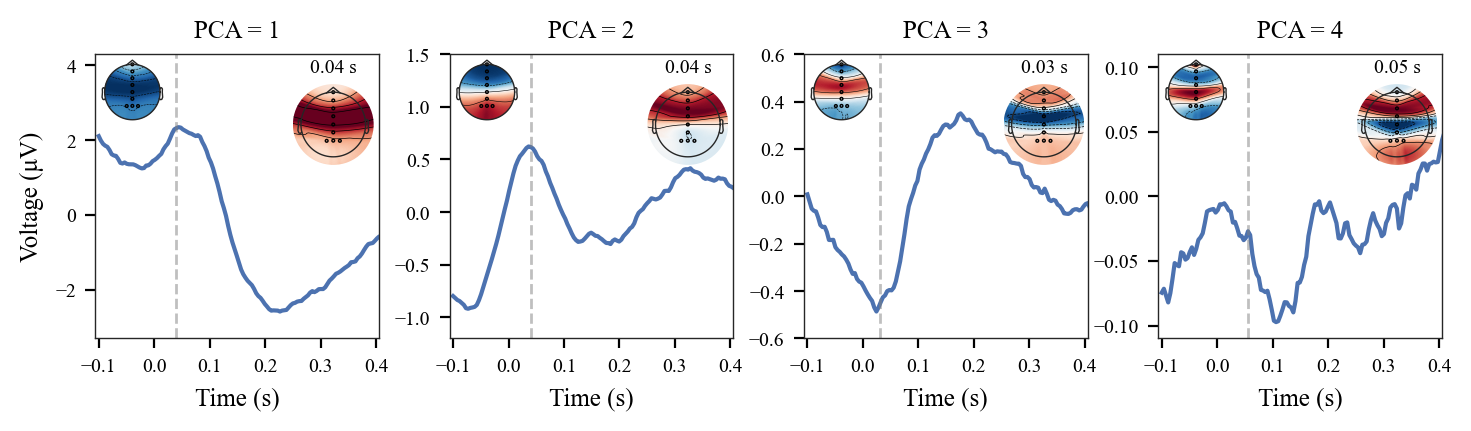

In [34]:
plot_ern_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evoke, 
    roi_name='1', 
    save=False
)

#### ERN ROI 2

In [35]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_2_pipeline, 
    roi_2, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


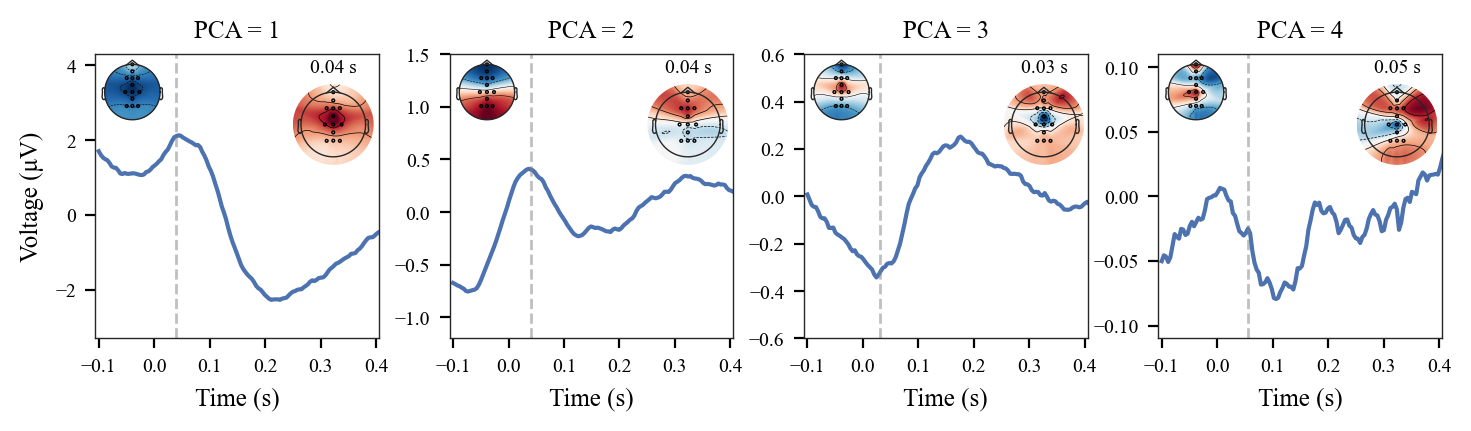

In [36]:
plot_ern_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evokes, 
    roi_name='2', 
    save=False
)

## Plot Pe patterns and filters

#### Pe ROI 3

In [69]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_3_pipeline, 
    roi_3, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


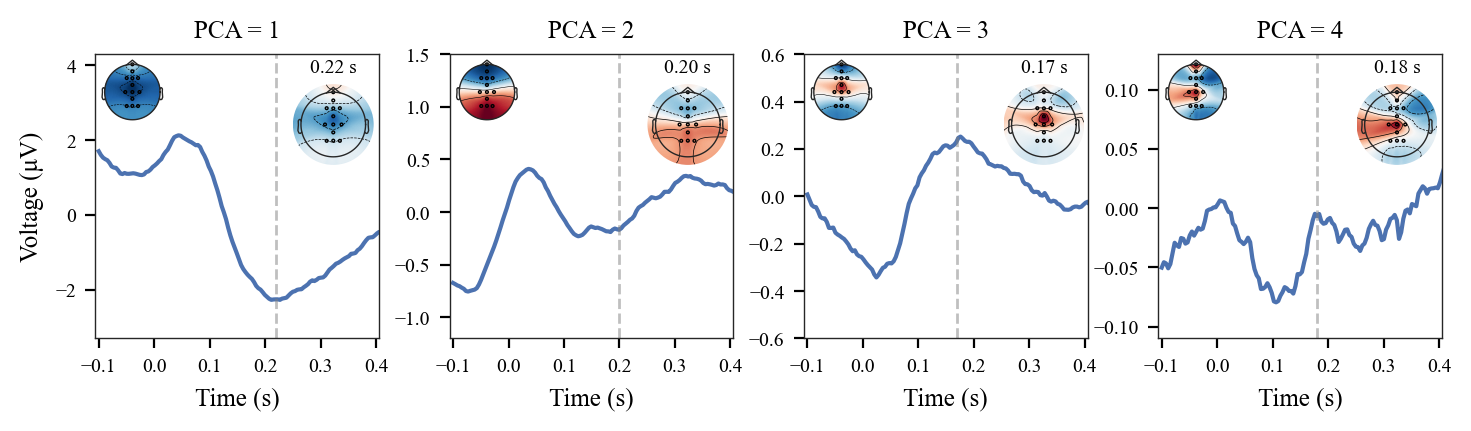

In [37]:
plot_pe_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evokes, 
    roi_name='3', 
    save=False
)

#### Pe ROI 4

In [40]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_4_pipeline, 
    roi_4, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


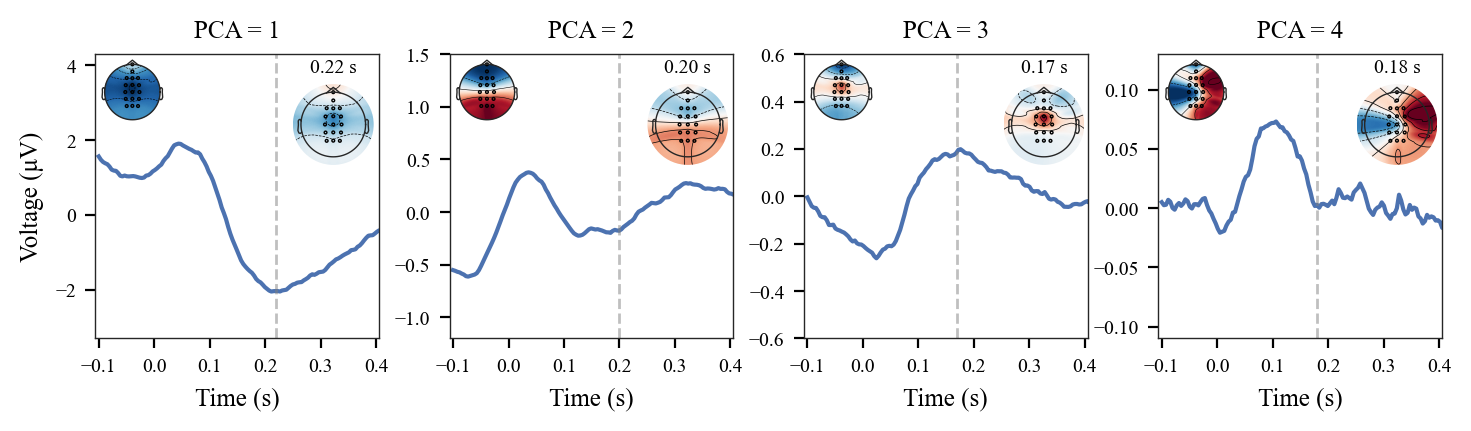

In [41]:
plot_pe_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evokes, 
    roi_name='4', 
    save=False
)